In [1]:
# prompt: google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Read data

In [161]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/628Mod4/podcast_episodes.csv')
df.head()
df.shape

(21898, 8)

In [162]:
df = df.drop_duplicates(subset=['Episode Name', 'Episode ID'], keep='first').reset_index(drop=True)

In [163]:
df.shape

(18466, 8)

In [149]:
df.to_csv('/content/drive/MyDrive/628Mod4/podcast_episodes1.csv', index=False)

In [150]:
import pandas as pd
cleaned_df = pd.read_csv('/content/drive/MyDrive/628Mod4/podcast_episodes_cleaned.csv')
cleaned_df.head()
cleaned_df.shape

(21898, 8)

In [151]:
cleaned_df = cleaned_df.drop_duplicates(subset=['Episode Name', 'Episode ID'], keep='first').reset_index(drop=True)

In [152]:
cleaned_df.shape

(18466, 8)

In [153]:
cleaned_df.to_csv('/content/drive/MyDrive/628Mod4/podcast_episodes_cleaned1.csv', index=False)

In [158]:
import pandas as pd

duplicates = cleaned_df[cleaned_df[['Episode Name','Episode ID']].duplicated(keep=False)]  # `keep=False`表示显示所有重复行

print(duplicates)


Empty DataFrame
Columns: [Episode Name, Episode ID, Description, Release Date, Duration (minutes), Show Name, Show ID, Category]
Index: []


#Naive Bayes


## Decide best alpha

In [ ]:
# Find best alpha
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'alpha': [0.1, 0.5, 1, 2],
# }

# grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=5, scoring='accuracy')
# grid_search.fit(X_train, y_train)

# print(f'Best parameters: {grid_search.best_params_}')
# print(f'Best cross-validation accuracy: {grid_search.best_score_}')

Best parameters: {'alpha': 0.1}
Best cross-validation accuracy: 0.681812686321053


In [155]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import pandas as pd

data = cleaned_df.copy()

data = data.dropna(subset=['Description', 'Category'])

X = data['Description']
y = data['Category']

if y.nunique() < 2:
    raise ValueError("Not enough unique categories in the dataset for classification.")

vectorizer = TfidfVectorizer(stop_words='english')
X_tfidf = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

alpha_best = 0.1
model = MultinomialNB(alpha = alpha_best)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

y_pred_prob = model.predict_proba(X_tfidf)

label_names = model.classes_

probability_columns = pd.DataFrame(y_pred_prob, columns=[f'{label}_Score' for label in label_names])

data = pd.concat([data, probability_columns], axis=1)

print(data.head())
import pandas as pd

def add_max_score_column(df):

    score_columns = [col for col in df.columns if col.endswith('_Score')]

    max_score_column = df[score_columns].idxmax(axis=1)

    df['max_score_column'] = max_score_column.str.replace('_Score', '', regex=False)

    return df

bayes_df = add_max_score_column(data)

print(bayes_df.head())

Accuracy: 0.8492324561403509
                                        Episode Name              Episode ID  \
0                  Cody Renard Richard & Carrie Wood  5uXBfMhL9rbUKQaZLQZaFD   
1                     Carlos Gacharna & Geof Hermann  7dCEFEbrvs7Efr4DriVBoZ   
2                       Jonathan Groff & Linda Tough  409iSTKN6X37pI9aOpVeKc   
3                                       WE'RE BACK!!  5xBZeMzgoDIK95ad8HwpmS   
4  Top Chef's Valentine Howell, Jr. with... his m...  3qfyXzLyCD8rv9twjH5qYF   

                                         Description Release Date  \
0  broadway tvs finest production stage manager c...   2024-11-30   
1  multimedia artist teaching artist around badas...   2024-11-21   
2  broadways reigning tonyaward winner best actor...   2024-11-14   
3  erica alek back gon na semiweekly podcast new ...   2024-11-07   
4  many firsttime ingredients spice episode weve ...   2024-04-02   

   Duration (minutes)                      Show Name                 Show I

<ipython-input-155-a08c21d048b5>:44: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_score_column = df[score_columns].idxmax(axis=1)


In [156]:
bayes_df.to_csv('/content/drive/MyDrive/628Mod4/bayes_df1.csv', index=False)

## Select samples showed in Shiny

In [ ]:
data1 = data.iloc[:,8:21]

In [ ]:
data.iloc[3593,:]

,3620
Episode Name,How Your Inventory Might Just Be Costing You S...
Episode ID,4x9ri7JOKwHro9yogzqwyI
Description,7 lessons ive learned years inventory cost mon...
Release Date,2024-05-27
Duration (minutes),17.8738
Show Name,Badass Small Business Owner
Show ID,0fDl7wKI5rYGnSUS0mnrcg
Category,business
arts_Score,0.039011
business_Score,0.446535


In [ ]:
import pandas as pd
max_indices = data1.idxmax()
print(max_indices)

arts_Score              1467
business_Score          3593
educational_Score       4809
entertainment_Score     6310
games_Score             8602
health_Score            9494
lifestyle_Score        11740
news_Score             13091
politics_Score         14536
recreation_Score       16433
sports_Score           18160
technology_Score       18656
true crime_Score       20179
dtype: int64


## The most similar episode

In [51]:
#Add raw description for output
def add_raw_description(df, bayes_df):

    df = df.rename(columns={'Description': 'Raw Description'})

    bayes_df = bayes_df.merge(df[['Episode ID', 'Raw Description']], on='Episode ID', how='left')

    return bayes_df

bayes_df = add_raw_description(df, bayes_df)
print(bayes_df.head())

                                        Episode Name              Episode ID  \
0                  Cody Renard Richard & Carrie Wood  5uXBfMhL9rbUKQaZLQZaFD   
1                     Carlos Gacharna & Geof Hermann  7dCEFEbrvs7Efr4DriVBoZ   
2                       Jonathan Groff & Linda Tough  409iSTKN6X37pI9aOpVeKc   
3                                       WE'RE BACK!!  5xBZeMzgoDIK95ad8HwpmS   
4  Top Chef's Valentine Howell, Jr. with... his m...  3qfyXzLyCD8rv9twjH5qYF   

                                         Description Release Date  \
0  broadway tvs finest production stage manager c...   2024-11-30   
1  multimedia artist teaching artist around badas...   2024-11-21   
2  broadways reigning tonyaward winner best actor...   2024-11-14   
3  erica alek back gon na semiweekly podcast new ...   2024-11-07   
4  many firsttime ingredients spice episode weve ...   2024-04-02   

   Duration (minutes)                      Show Name                 Show ID  \
0           61.728217  A

In [53]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = TfidfVectorizer(stop_words='english')

X_tfidf = vectorizer.fit_transform(bayes_df['Description'].fillna(''))

def get_similar_episodes(episode_name, top_n=5):

    result = bayes_df[bayes_df['Episode Name'] == episode_name]

    if result.empty:
        return "Episode not found."

    input_episode = result['Description'].iloc[0]

    input_tfidf = vectorizer.transform([input_episode])

    similarity_scores = cosine_similarity(input_tfidf, X_tfidf)

    similar_indices = similarity_scores.argsort()[0][-top_n:][::-1]

    similar_indices = [idx for idx in similar_indices if bayes_df.iloc[idx]['Episode Name'] != episode_name]

    top_n_filtered = len(similar_indices) if len(similar_indices) < top_n else top_n

    similar_episodes = bayes_df.iloc[similar_indices]
    similarity_values = similarity_scores[0][similar_indices]

    result_df = pd.DataFrame({
        'Show Name': similar_episodes['Show Name'].values,
        'Episode Name': similar_episodes['Episode Name'].values,
        'Description': similar_episodes['Raw Description'].values,
        'Category': similar_episodes['Category'].values,
        'Similarity Score': similarity_values
    })

    return result_df

episode_name_input = "Ep 9 ACOWAR: Chapters 61-68"
similar_episodes_df = get_similar_episodes(episode_name_input)

print(similar_episodes_df)


          Show Name                  Episode Name  \
0  Fantasy Fangirls  Ep 11 ACOWAR: Chapters 75-82   
1  Fantasy Fangirls   Ep 8 ACOWAR: Chapters 49-60   
2  Fantasy Fangirls   Ep 6 ACOWAR: Chapters 35-41   
3  Fantasy Fangirls    Ep 1 ACOFAS: Chapters 1-14   

                                         Description Category  \
0  Two sisters, Nicole and Lexi explore chapters ...     arts   
1  Two sisters, Nicole and Lexi explore chapters ...     arts   
2  Two sisters, Nicole and Lexi explore chapters ...     arts   
3  Two sisters, Nicole and Lexi explore chapters ...     arts   

   Similarity Score  
0          0.710779  
1          0.698670  
2          0.697357  
3          0.679503  


## The most similar podcast

In [54]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


def find_similar_podcasts(podcast_name, df, top_n=5):

    df['Description'] = df['Description'].fillna('').astype(str)
    grouped = df.groupby('Show Name')['Description'].apply(lambda x: ' '.join(x)).reset_index()

    if podcast_name not in grouped['Show Name'].values:
        raise ValueError(f"Podcast '{podcast_name}' not found in the dataset.")

    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(grouped['Description'])

    input_idx = grouped[grouped['Show Name'] == podcast_name].index[0]
    input_vector = tfidf_matrix[input_idx]

    similarity_scores = cosine_similarity(input_vector, tfidf_matrix).flatten()

    similar_indices = similarity_scores.argsort()[::-1][1:top_n + 1]
    similar_podcasts = grouped.iloc[similar_indices]
    similarity_values = similarity_scores[similar_indices]

    similar_podcasts['Category'] = similar_podcasts['Show Name'].apply(lambda x: df[df['Show Name'] == x]['Category'].values[0])

    result_df = pd.DataFrame({
        'Podcast Name': similar_podcasts['Show Name'].values,
        'Category': similar_podcasts['Category'].values,
        'Similarity Score': similarity_values
    })

    return result_df

podcast_name = "Badass Small Business Owner"
similar_podcasts_df = find_similar_podcasts(podcast_name, df)

print(similar_podcasts_df)


                             Podcast Name  Category  Similarity Score
0                    Business Made Simple  business          0.238460
1         Motivation Daily by Motiversity  business          0.210208
2      Small Business Tax Savings Podcast  business          0.208651
3  The Business Credit and Financing Show  business          0.208150
4        The Business Development Podcast  business          0.189024


<ipython-input-54-d3f2f6193cc9>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  similar_podcasts['Category'] = similar_podcasts['Show Name'].apply(lambda x: df[df['Show Name'] == x]['Category'].values[0])


#LDA

## Decide the topic number of LDA

In [56]:

import pandas as pd
from gensim.models import LdaMulticore
from gensim import corpora


descriptions = cleaned_df['Description'].dropna().tolist()

processed_descriptions = [desc.split() for desc in descriptions]


dictionary = corpora.Dictionary(processed_descriptions)
corpus = [dictionary.doc2bow(text) for text in processed_descriptions]
perplexities = []
topic_range = range(4, 13)
for num_topics in topic_range:
    lda_model = LdaMulticore(corpus, num_topics=num_topics, id2word=dictionary, passes=10, workers=2)
    perplexity = lda_model.log_perplexity(corpus)
    perplexities.append(perplexity)

import matplotlib.pyplot as plt
plt.plot(topic_range, perplexities)
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity')
plt.title('Perplexity vs. Number of Topics')
plt.show()


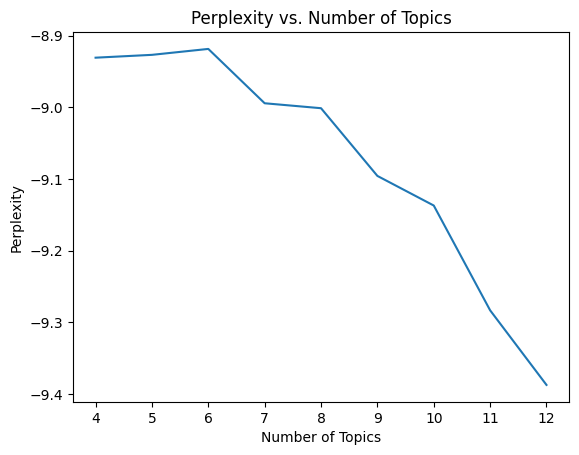

In [ ]:
plt.plot(topic_range, perplexities)
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity')
plt.title('Perplexity vs. Number of Topics')
plt.show()

## Exclude mannual stop words

In [164]:
mannual_stop_words = ['episode', 'podcast', 'get', 'us', 'like', 'visit', 'go', 'youtube', 'also', 'instagram', 'use']

def clean_text(text):

    stop_words = mannual_stop_words

    if not isinstance(text, str):
        return ''

    text = text.strip()
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

df = cleaned_df.copy()
df['Cleaned_Description'] = df['Description'].apply(clean_text)

## Decide number of PCA components

In [59]:
#How to choose number of PCA
pca = PCA(n_components=lda_topic_distribution.shape[1])
pca.fit(lda_topic_distribution)

plt.figure(figsize=(10, 6))
plt.plot(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.title('Explained Variance Ratio by PCA Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

print(f"Cumulative explained variance: {cumulative_explained_variance}")

n_components_selected = np.argmax(cumulative_explained_variance >= 0.90) + 1  #
print(f"number of components：{n_components_selected}")

pca = PCA(n_components=2)
lda_topic_2d = pca.fit_transform(lda_topic_distribution)

explained_variance = pca.explained_variance_ratio_.sum()
print(f"PCA percentage: {explained_variance * 100:.2f}%")


Topic 0: privacy trump news election policy trumps choices new omnystudiocomlistener donald
Topic 1: business journey personal strategies success importance shares life insights new
Topic 2: learn ad choices podcastchoicescomadchoices follow week new nfl megaphonefmadchoices football
Topic 3: health dr learn life mental food help book body anxiety
Topic 4: want check free business make time know dont youre click
Topic 5: la en el que investment account bond tax del investing
Topic 6: games new game producer live sports media national twitter join
Topic 7: join free podcasts episodes subscribe learn access ad apple follow
Topic 8: apple hosted sleep information acast acastcomprivacy music sounds noise white
Topic 9: code free 20 order 10 15 today support facebook promo
Topic 10: ai news world technology future 2024 daily data human english
Topic 11: story true crime people life years case murder stories time
PCA解释的方差比例: 92.75%
                                        Episode Name        

<ipython-input-165-c12293d4f1e4>:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=topic_means.index, y=topic_means.values, palette='viridis')


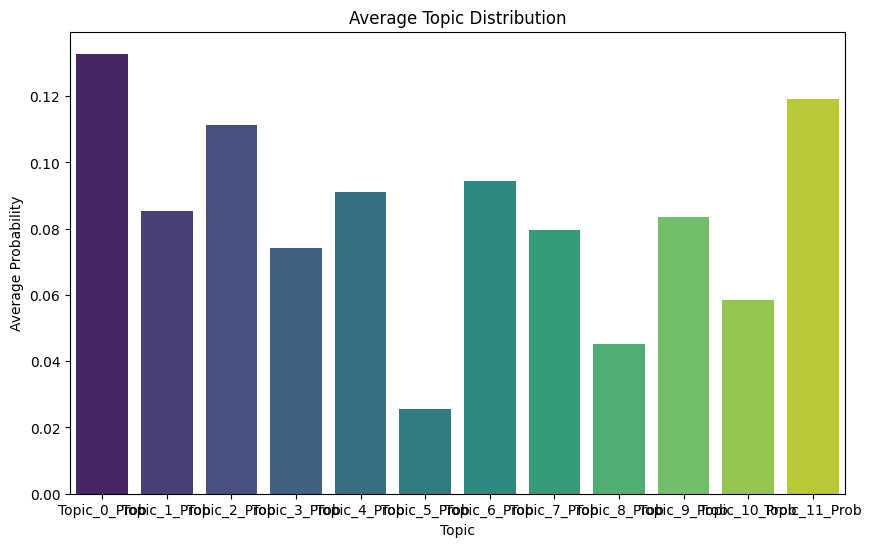

                                        Episode Name              Episode ID  \
0                  Cody Renard Richard & Carrie Wood  5uXBfMhL9rbUKQaZLQZaFD   
1                     Carlos Gacharna & Geof Hermann  7dCEFEbrvs7Efr4DriVBoZ   
2                       Jonathan Groff & Linda Tough  409iSTKN6X37pI9aOpVeKc   
3                                       WE'RE BACK!!  5xBZeMzgoDIK95ad8HwpmS   
4  Top Chef's Valentine Howell, Jr. with... his m...  3qfyXzLyCD8rv9twjH5qYF   

                                         Description Release Date  \
0  broadway tvs finest production stage manager c...   2024-11-30   
1  multimedia artist teaching artist around badas...   2024-11-21   
2  broadways reigning tonyaward winner best actor...   2024-11-14   
3  erica alek back gon na semiweekly podcast new ...   2024-11-07   
4  many firsttime ingredients spice episode weve ...   2024-04-02   

   Duration (minutes)                      Show Name                 Show ID  \
0           61.728217  A

In [165]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df['Cleaned_Description'] = df['Cleaned_Description'].fillna('')

vectorizer = CountVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(df['Cleaned_Description'])

lda = LatentDirichletAllocation(n_components=12, random_state=42)
lda_topic_distribution = lda.fit_transform(X)

def display_topics(model, feature_names, no_top_words):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_features = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        topics.append(f"Topic {topic_idx}: {' '.join(top_features)}")
    return topics

feature_names = vectorizer.get_feature_names_out()
topics = display_topics(lda, feature_names, 10)
for topic in topics:
    print(topic)

for i in range(12):
    df[f'Topic_{i}_Prob'] = lda_topic_distribution[:, i]

pca = PCA(n_components=9)
lda_topic_2d = pca.fit_transform(lda_topic_distribution)

explained_variance = pca.explained_variance_ratio_.sum()
print(f"PCA解释的方差比例: {explained_variance * 100:.2f}%")
for i in range(9):
    df[f'PCA{i + 1}'] = lda_topic_2d[:, i]

print(df.head())

df['Dominant_Topic'] = lda_topic_distribution.argmax(axis=1)

topic_means = df[[f'Topic_{i}_Prob' for i in range(12)]].mean()
plt.figure(figsize=(10, 6))
sns.barplot(x=topic_means.index, y=topic_means.values, palette='viridis')
plt.title('Average Topic Distribution')
plt.xlabel('Topic')
plt.ylabel('Average Probability')
plt.show()
lda_df = df.copy()

print(lda_df.head())


In [169]:
lda_df.shape

(18466, 31)

In [170]:
lda_df.to_csv('/content/drive/MyDrive/628Mod4/lda_df1.csv', index=False)

In [159]:
duplicates_lda = df[df[['Episode Name','Episode ID']].duplicated(keep=False)]

print(duplicates_lda)

Empty DataFrame
Columns: [Episode Name, Episode ID, Description, Release Date, Duration (minutes), Show Name, Show ID, Category]
Index: []


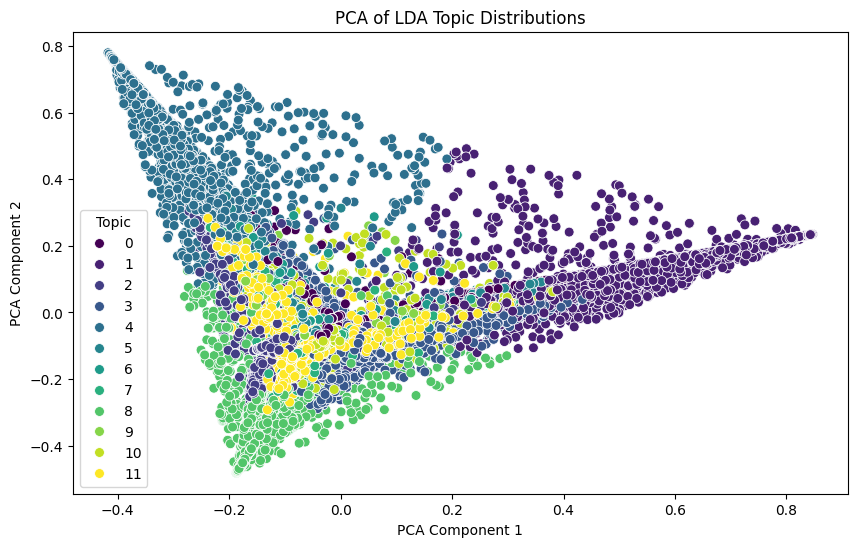

In [ ]:
df['Dominant_Topic'] = lda_topic_distribution.argmax(axis=1)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='Dominant_Topic', palette='viridis', s=50, legend='full')
plt.title('PCA of LDA Topic Distributions')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Topic')
plt.show()


##LDA similar episode

In [105]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

cos_sim_matrix = cosine_similarity(lda_topic_distribution)

cos_sim_df = pd.DataFrame(cos_sim_matrix, index=df.index, columns=df.index)

print(cos_sim_df.head())

episode_index = 0
top_similar_episodes = cos_sim_df.iloc[episode_index].sort_values(ascending=False)[1:6]

print(f"与 Episode {episode_index} 最相似的 Episodes:")
print(top_similar_episodes)

similar_episodes_info = df.loc[top_similar_episodes.index]
print(similar_episodes_info)


      0         1         2         3         4         5         6      \
0  1.000000  0.024268  0.701352  0.357739  0.428047  0.455156  0.483947   
1  0.024268  1.000000  0.432325  0.019895  0.569152  0.801808  0.320390   
2  0.701352  0.432325  1.000000  0.424355  0.739819  0.866436  0.701985   
3  0.357739  0.019895  0.424355  1.000000  0.256304  0.273483  0.290629   
4  0.428047  0.569152  0.739819  0.256304  1.000000  0.765346  0.931904   

      7         8         9      ...     18456     18457     18458     18459  \
0  0.292401  0.324723  0.398746  ...  0.740180  0.740180  0.715790  0.674712   
1  0.018137  0.291985  0.022002  ...  0.017457  0.017457  0.016819  0.014050   
2  0.348161  0.500878  0.040584  ...  0.881783  0.881783  0.853035  0.805040   
3  0.531685  0.288605  0.027590  ...  0.443082  0.443082  0.428226  0.402486   
4  0.692454  0.917140  0.013807  ...  0.535429  0.535429  0.516397  0.483989   

      18460     18461     18462     18463     18464     18465  
0  0

In [140]:
df_temp = df.copy()

In [141]:
import pandas as pd

def find_similar_episodes(episode_name, cos_sim_df, df):
    if episode_name not in df['Episode Name'].values:
        raise ValueError(f"Episode '{episode_name}' not found in the dataset.")

    episode_index = df[df['Episode Name'] == episode_name].index[0]

    similar_episodes = cos_sim_df.iloc[episode_index].sort_values(ascending=False)[1:6]

    similar_episode_indices = similar_episodes.index

    if not all(idx in df.index for idx in similar_episode_indices):
        raise IndexError("One or more of the similar episode indices are out of bounds.")

    similar_episodes_info = df.iloc[similar_episode_indices]

    result_df = pd.DataFrame({
        'Show Name': similar_episodes_info['Show Name'].values,
        'Episode Name': similar_episodes_info['Episode Name'].values,
        'Description': similar_episodes_info['Description'].values,
        'Category': similar_episodes_info['Category'].values,
        'Topic': similar_episodes_info['Dominant_Topic'].values,
        "Similarity Score": similar_episodes.values
    })

    return result_df

episode_name = 'Ep 9 ACOWAR: Chapters 61-68'
result_df = find_similar_episodes(episode_name, cos_sim_df, df)

print(result_df)



             Show Name                                       Episode Name  \
0     Fantasy Fangirls                       Ep 11 ACOWAR: Chapters 75-82   
1     Fantasy Fangirls                        Ep 7 ACOWAR: Chapters 42-48   
2     Fantasy Fangirls                        Ep 8 ACOWAR: Chapters 49-60   
3  Danny Jones Podcast  #256 - Top Investigator: NEW Epstein Files & '...   
4              Candace  Matt Gaetz Out, Jussie Smollett Walks Free! | ...   

                                         Description    Category  Topic  \
0  two sisters nicole lexi explore chapters 7582 ...        arts      9   
1  two sisters nicole lexi explore chapters 4248 ...        arts      9   
2  two sisters nicole lexi explore chapters 4960 ...        arts      9   
3  watch episode uncensored adfree patreon bryant...  technology      9   
4  jussie smolletts conviction overturned illinoi...    politics      9   

   Similarity Score  
0          0.999986  
1          0.999931  
2          0.999904 

## LDA similar podcast

In [142]:
import pandas as pd

def find_similar_podcast(podcast_name, cos_sim_df, df, top_n=5):

    if podcast_name not in df['Show Name'].values:
        raise ValueError(f"Podcast '{podcast_name}' not found in the dataset.")

    podcast_episode_indices = df[df['Show Name'] == podcast_name].index.tolist()

    podcast_candidates = []

    for episode_index in podcast_episode_indices:

        similar_episodes = cos_sim_df.iloc[episode_index].sort_values(ascending=False).index[1:]

        for similar_episode_index in similar_episodes:
            similar_podcast_name = df.loc[similar_episode_index, 'Show Name']
            if similar_podcast_name != podcast_name:
                podcast_candidates.append(similar_podcast_name)

    if not podcast_candidates:
        return pd.DataFrame({
            'Podcast Name': [],
            'Category': [],
            'Topic Number': [],
            'Similarity Score': []
        })

    podcast_frequency = pd.Series(podcast_candidates).value_counts()

    top_podcasts = podcast_frequency.head(top_n).index
    similarity_scores = podcast_frequency.head(top_n).values

    categories = []
    topic_numbers = []

    for podcast in top_podcasts:
        category = df[df['Show Name'] == podcast].iloc[0]['Category']
        categories.append(category)

        topics = df[df['Show Name'] == podcast]['Dominant_Topic']
        most_frequent_topic = topics.mode().iloc[0]
        topic_numbers.append(most_frequent_topic)

    result_df = pd.DataFrame({
        'Podcast Name': top_podcasts,
        'Category': categories,
        'Topic Number': topic_numbers,
        'Similarity Score': similarity_scores
    })

    return result_df


In [145]:

podcast_name = "Arts Educators Save the World"

similar_podcasts_df = find_similar_podcast(podcast_name, cos_sim_df, df, top_n=5)

print(similar_podcasts_df)


  Podcast Name  Similarity Score
0         News              1300
1   True Crime              1100
2     Politics              1100
3       Health               960
4     Business               860
